In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The goal here is to predict which previously purchased products will be in a user’s next order.

In [38]:
aisles = pd.read_csv('../input/instacart-market-basket-analysis/aisles.csv')
depts = pd.read_csv('../input/instacart-market-basket-analysis/departments.csv')
orders_prior = pd.read_csv('../input/instacart-market-basket-analysis/order_products__prior.csv')
orders_train = pd.read_csv('../input/instacart-market-basket-analysis/order_products__train.csv')
orders = pd.read_csv('../input/instacart-market-basket-analysis/orders.csv')
products = pd.read_csv('../input/instacart-market-basket-analysis/products.csv')

Let's start by looking at each of the inputs: their contents and sizes.

In [39]:
aisles.tail(3)

,aisle_id,aisle
131,132,beauty
132,133,muscles joints pain relief
133,134,specialty wines champagnes


In [40]:
depts.tail(3)

,department_id,department
18,19,snacks
19,20,deli
20,21,missing


In [41]:
orders_prior.tail(3)

,order_id,product_id,add_to_cart_order,reordered
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [42]:
orders_train.tail(3)

,order_id,product_id,add_to_cart_order,reordered
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [43]:
orders.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [44]:
products.tail(3)

,product_id,product_name,aisle_id,department_id
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


Orders is clearly the most important of the inputs and contains the most information to digest. It has 3421083 rows and 7 columns. Let's look at it in more detail.

Text(0, 0.5, 'No. of orders')

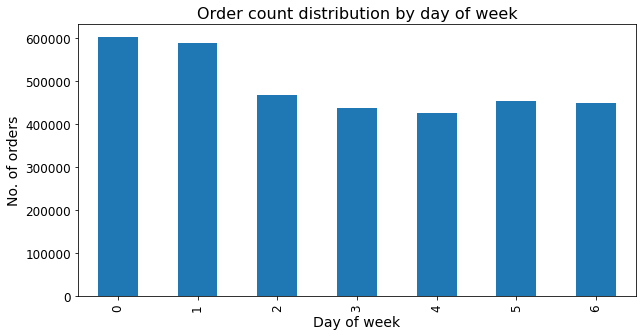

In [45]:
ax = orders['order_dow'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Order count distribution by day of week',fontsize=16)
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

It's not mentioned explicitly, but I assumed 0 to mean Sunday, 1 Monday and so on. I expected the number of orders to be highest on weekends, but judging from the plot above, I'm confused if the orders are highest on Sunday and Monday (since it is online ordering) or if 0 refers to Saturday in this case. I have to check further on this.

Text(0, 0.5, 'No. of orders')

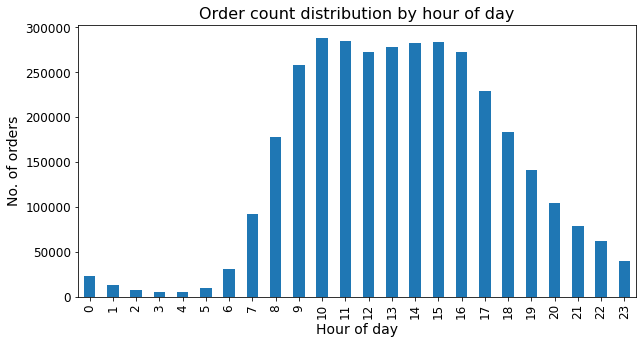

In [46]:
ax = orders['order_hour_of_day'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Order count distribution by hour of day',fontsize=16)
ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

This is an expected distribution. Most of the orders are in the daytime while ordering at night is still possible since Instacart is an online service.

The products contained in an order are present in orders_prior and orders_train. My understanding after reading https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2 is that since the goal is to predict the products in an order, the last order of a user is separated out from the previous orders. These previous orders are in orders_prior. orders_train is used as training data for the model. There are also some orders left out which can be used as a test set for predictions. This test test can be fetched from the main orders df since it contains the eval_set column.

In [47]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [48]:
eval_set_user_counts = orders.drop_duplicates(subset=['user_id', 'eval_set'])['eval_set'].value_counts()
eval_set_user_counts

prior    206209
train    131209
test      75000
Name: eval_set, dtype: int64

In [49]:
len(orders['user_id'].unique())

206209

In [50]:
eval_set_user_counts['train'] + eval_set_user_counts['test']

206209

In [51]:
prior_orders = orders.loc[orders['eval_set'] == 'prior']
prior_orders['order_number'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [52]:
train_set = orders.loc[orders['eval_set'] == 'train']
test_set = orders.loc[orders['eval_set'] == 'test']

In [53]:
train_set['order_number'].sort_values().unique()

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100])

In [54]:
test_set['order_number'].sort_values().unique()

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100])

From the above snippets, we see that of the total 206209 users, their last orders have been split into train and test eval_sets

Text(0, 0.5, 'No. of orders')

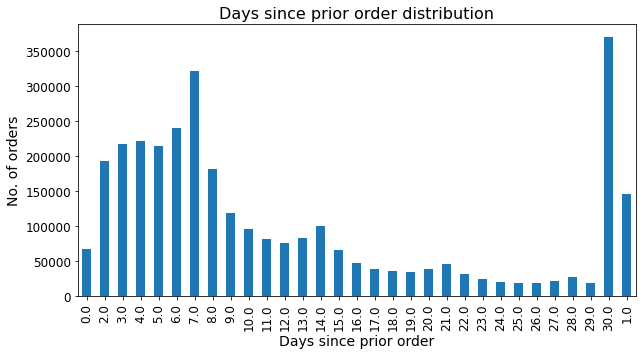

In [60]:
ax = orders['days_since_prior_order'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Days since prior order distribution',fontsize=16)
ax.set_xlabel('Days since prior order', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

Text(0, 0.5, 'No. of orders with that product')

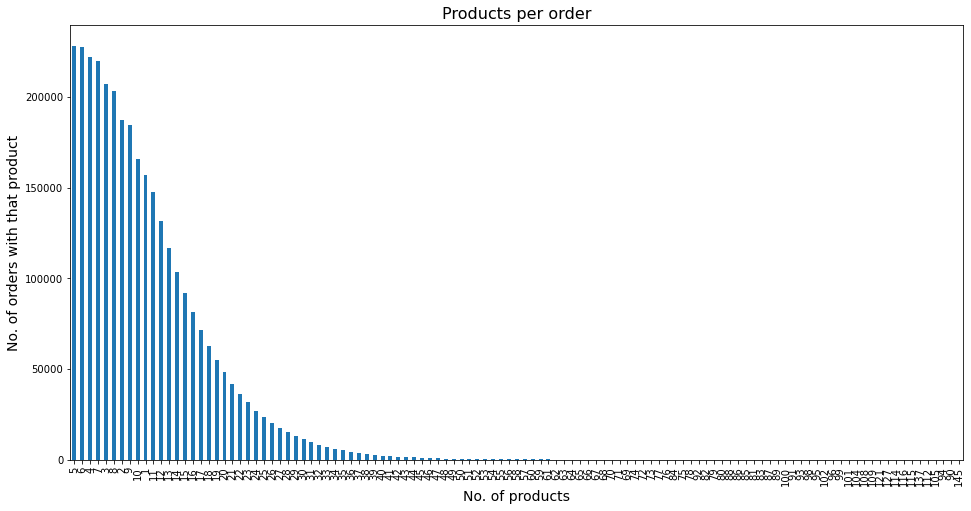

In [62]:
ax = orders_prior.groupby('order_id')['add_to_cart_order'].max().value_counts().plot(kind='bar', figsize=(16,8), fontsize=10)
ax.set_title('Products per order',fontsize=16)
ax.set_xlabel('No. of products', fontsize=14)
ax.set_ylabel('No. of orders with that many products', fontsize=14)

In [ ]:
# orders_prior['reordered'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
# ax.set_title('Reordered count',fontsize=16)
# ax.set_xlabel('Reordered', fontsize=14)
# ax.set_ylabel('No. of orders', fontsize=14)